# 2 Neural Networks

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')
#unzip
!unzip /content/drive/MyDrive/archive.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/archive.zip
  inflating: dataset2.csv            


## Model 1 with simple multilayer neural net
Import Dataset and perform random_underampling

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

# Load the dataset
df = pd.read_csv('/content/dataset2.csv', engine='pyarrow')

# Drop all rows with NaN values
df.dropna(inplace=True)

def perform_random_undersampling(df, target_column, minority_class='rope jumping'):
    minority_class_len = len(df[df[target_column] == minority_class])
    indices = []
    for i in np.unique(df[target_column]):
        class_indices = df[df[target_column] == i].index
        sampled_indices = np.random.choice(class_indices, minority_class_len, replace=False)
        indices.extend(sampled_indices)
    np.random.shuffle(indices)
    return df.loc[indices]

df_undersample = perform_random_undersampling(df, 'activityID')

Training the model. Iterating 5 times and take average accuracy of all models:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dense, Dropout, LeakyReLU

import copy
import pandas as pd

# Your existing code for data preparation...


# apply one hot encoding
Y = pd.get_dummies(df_undersample['activityID'])
X = df_undersample.drop(['activityID', 'PeopleId'], axis=1, inplace=False)

average_accuracys = []
for k in range(5):
  historys = []
  for i in range(1, 9):
      print('PeopleID_mask: ', i)
      # Mask for train and test split
      mask_train = (df_undersample['PeopleId'] != i)

      y_train = Y[mask_train]
      X_train = X[mask_train]

      # validation on
      mask_valid = (df['PeopleId'] == i)
      y_test = pd.get_dummies(df['activityID'])[mask_valid]
      X_test = df.drop(['activityID', 'PeopleId'], axis = 1, inplace = False)[mask_valid]


      # Build a neural network with Leaky ReLU and Batch Normalization
      model = Sequential([
          BatchNormalization(input_shape=(X_train.shape[1],)),  # Batch Normalization as the first layer
          Dense(300),
          LeakyReLU(alpha=0.01),  # You can adjust the alpha parameter as needed
          Dropout(0.5),
          Dense(100),
          LeakyReLU(alpha=0.01),
          Dense(y_train.shape[1], activation='softmax')
      ])


      # Compile the model
      model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


      # Train the model with the ModelCheckpoint callback
      history = model.fit(X_train, y_train,
                          epochs=15,
                          batch_size=300,
                          validation_data=[X_test, y_test])

      historys.append(copy.deepcopy(history))
  accuracy_values = []
  for i in range(1,9):
        # Extract the accuracy from the evaluation results
        accuracy = max(historys[i-1].history['val_accuracy'])
        # Print the accuracy for each model
        print(f"Accuracy for Model {i}: {accuracy}")
        # Append accuracy to the list
        accuracy_values.append(accuracy)

  print('AVG accuracy: ', np.average(accuracy_values))
  print('STD accuracy: ', np.std(accuracy_values) )
  average_accuracys.append(np.average(accuracy_values))


Average accuracy and standart deviation:




In [11]:
print('Average accuracys in percent: ',average_accuracys)
print('Final everage accuracy; ',np.round(np.average(average_accuracys)*100,2), '%')
print('Final Standart deviation: ', np.round(np.std(average_accuracys)*100,2), '%')

Average accuracys in percent:  [0.5679332688450813, 0.5697894059121609, 0.573306068778038, 0.5729415751993656, 0.5709403343498707]
Final everage accuracy;  57.1 %
Final Standart deviation:  0.2 %


Plot model evolution of last run:

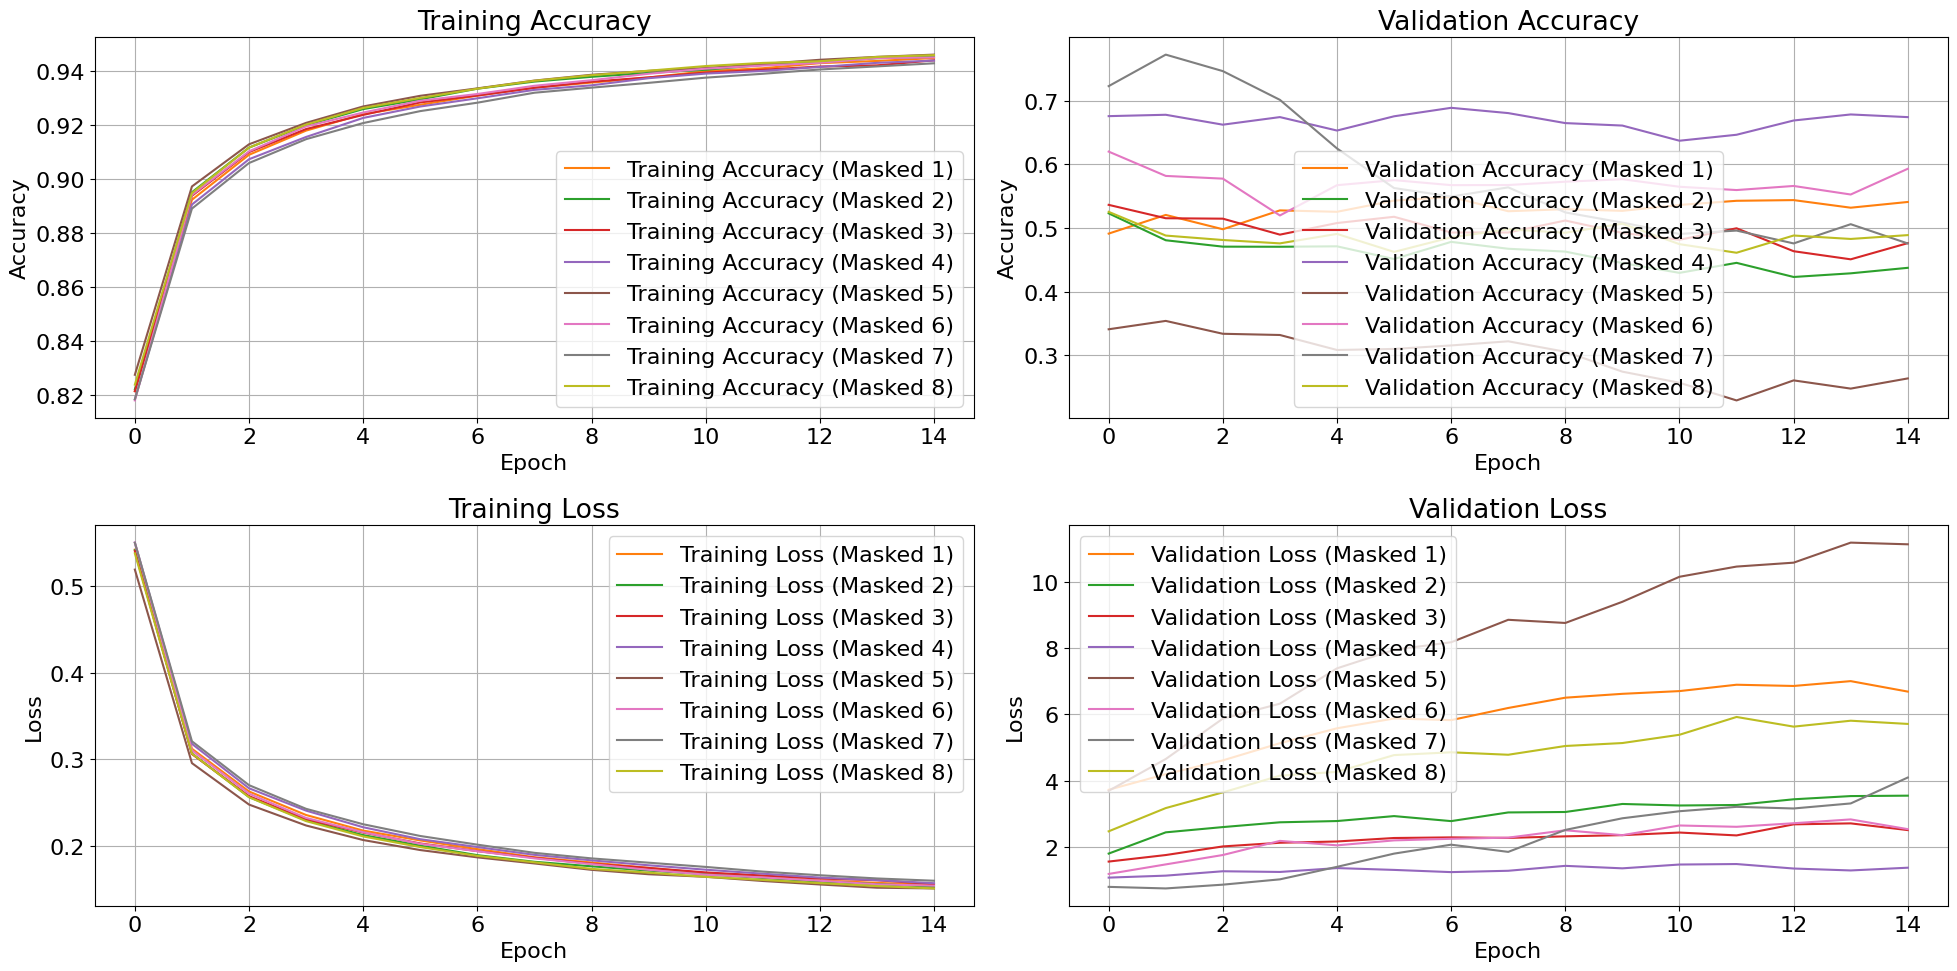

In [12]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))


# Iterate through trained models and their corresponding histories
for i in range(8):
    history = historys[i]

    # Plot Training Accuracy
    ax[0, 0].plot(history.history['accuracy'], label=f'Training Accuracy (Masked {i+1})', color=f'C{i+1}')
    ax[0, 0].set_title('Training Accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()
    ax[0,0].grid(True)


    # Plot Validation Accuracy
    ax[0, 1].plot(history.history['val_accuracy'], label=f'Validation Accuracy (Masked {i+1})', color=f'C{i+1}')
    ax[0, 1].set_title('Validation Accuracy')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Accuracy')
    ax[0, 1].legend()
    ax[0,1].grid(True)

    # Plot Training Loss
    ax[1, 0].plot(history.history['loss'], label=f'Training Loss (Masked {i+1})', color=f'C{i+1}')
    ax[1, 0].set_title('Training Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()
    ax[1,0].grid(True)

    # Plot Validation Loss
    ax[1, 1].plot(history.history['val_loss'], label=f'Validation Loss (Masked {i+1})', color=f'C{i+1}')
    ax[1, 1].set_title('Validation Loss')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    ax[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Best Average accuracy and standart deviation:

## Model 2 with LSTM neural net

Load, remove nans and undersample:

In [19]:
import pandas as pd
# Load the dataset
df = pd.read_csv('/content/dataset2.csv', engine='pyarrow')
# Drop all rows with NaN values
df.dropna(inplace=True)

df_undersample = perform_random_undersampling(df, 'activityID')

Windowed dataset for LSTM and random undersampling of the windows:

In [24]:
import numpy as np
def windowed_df_to_X_y_test_train(windowed_dataframe, df, window_size=100, step=10, mask = True, l = 1):
    X_train = windowed_dataframe.drop(['activityID', 'PeopleId'], axis=1, inplace = False)[~mask].to_numpy()
    Y_train = pd.get_dummies(windowed_dataframe['activityID'])[~mask].to_numpy()

    mask_valid = (df['PeopleId'] == l)
    X_val = df.drop(['activityID', 'PeopleId'], axis=1, inplace = False)[mask_valid].to_numpy()
    Y_val = pd.get_dummies(df['activityID'])[mask_valid].to_numpy()

    X_train_batch = []
    Y_train_batch = []
    X_val_batch = []
    Y_val_batch = []
    for i in range(0, len(X_train) - window_size, step):
        X_train_batch.append(X_train[i:i + window_size, :])
        Y_train_batch.append(Y_train[i + window_size, :])

    for i in range(0, len(X_val) - window_size, step):
        X_val_batch.append(X_val[i:i + window_size, :])
        Y_val_batch.append(Y_val[i + window_size, :])

    permutation_indices = np.random.permutation(len(X_train_batch))
    return np.array(X_train_batch, dtype = 'float32')[permutation_indices,:], np.array(Y_train_batch, dtype = 'float32')[permutation_indices,:],np.array(X_val_batch, dtype = 'float32'), np.array(Y_val_batch, dtype = 'float32')

def perform_random_undersampling(df, target_column, minority_class = 'rope jumping'):
    minority_class_len = len(df[df[target_column] == minority_class])
    indices = []
    for i in np.unique(df[target_column]):
        indices.extend(np.random.choice(df[df[target_column] == i].index, minority_class_len, replace=False))
    indices_sort = np.sort(indices)
    return df.loc[indices_sort]


Perform the fit:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
import copy
import numpy as np

# Hyperparameters for windows
window_size = 100
step = 20


average_accuracys = []

for k in range(5):
  x_tests_l = []
  y_tests_l = []
  trained_models_l = []
  historys_l = []
  for i in range(1,9):
    mask = (df_undersample['PeopleId'] == i)
    X_train_lstm, Y_train_lstm, X_val_lstm, Y_val_lstm = windowed_df_to_X_y_test_train(df_undersample, df , window_size=window_size, step = step, mask = mask, l = i)


    model = Sequential()
    model.add(BatchNormalization(input_shape=(window_size, 31)))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(13, activation='softmax'))

    adam_optimizer = Adam()

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    # Train the model using the generator
    history = model.fit(X_train_lstm, Y_train_lstm, epochs=20,
                        validation_data = (X_val_lstm, Y_val_lstm), verbose = 1, batch_size=50)
    trained_models_l.append(copy.deepcopy(model))
    historys_l.append(copy.deepcopy(history))

  accuracys = []
  for i in range(8):
      val_accuracy = max(historys_l[i].history['val_accuracy'])
      accuracys.append(val_accuracy)  # Store the accuracy

  print('average accuracy: ', np.average(accuracys))
  print('standart dviation: ', np.std(accuracys))
  average_accuracys.append(np.average(accuracys))


Average accuracy and standart deviation:

In [34]:
print('Average accuracys in percent: ',average_accuracys)
print('Final everage accuracy; ',np.round(np.average(average_accuracys)*100,2), '%')
print('Final Standart deviation: ', np.round(np.std(average_accuracys)*100,2), '%')

Average accuracys in percent:  [0.5995990671217442, 0.5802505798637867, 0.5824312828481197, 0.6047921665012836, 0.5841721408069134]
Final everage accuracy;  59.02 %
Final Standart deviation:  1.0 %


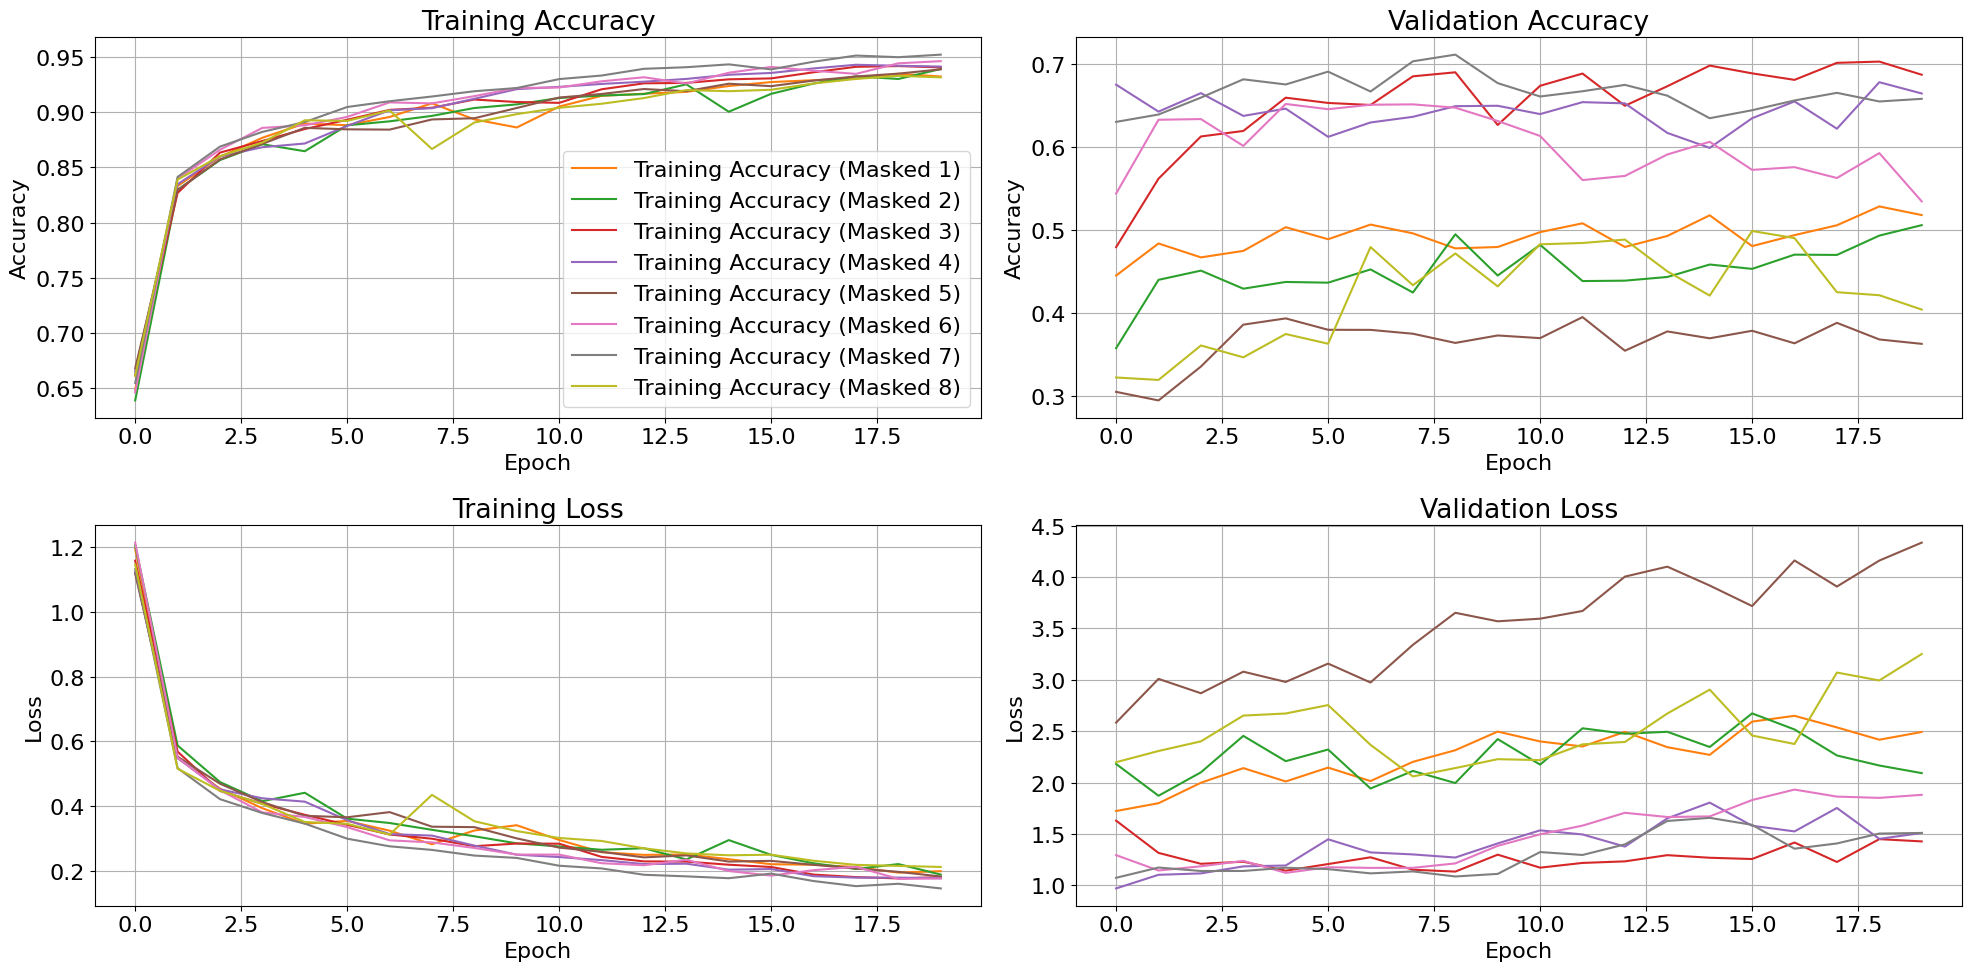

In [36]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))


# Iterate through trained models and their corresponding histories
for i in range(len(trained_models_l)):
    history = historys_l[i]

    # Plot Training Accuracy
    ax[0, 0].plot(history.history['accuracy'], label=f'Training Accuracy (Masked {i+1})', color=f'C{i+1}')
    ax[0, 0].set_title('Training Accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()
    ax[0,0].grid(True)


    # Plot Validation Accuracy
    ax[0, 1].plot(history.history['val_accuracy'], label=f'Validation Accuracy (Masked {i+1})', color=f'C{i+1}')
    ax[0, 1].set_title('Validation Accuracy')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Accuracy')
    ax[0,1].grid(True)

    # Plot Training Loss
    ax[1, 0].plot(history.history['loss'], label=f'Training Loss (Masked {i+1})', color=f'C{i+1}')
    ax[1, 0].set_title('Training Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1,0].grid(True)

    # Plot Validation Loss
    ax[1, 1].plot(history.history['val_loss'], label=f'Validation Loss (Masked {i+1})', color=f'C{i+1}')
    ax[1, 1].set_title('Validation Loss')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
